# Differential Privacy 이해 - 최대 가능도

환자 질병 유무 데이터가 주어질 때 환자별로 스피너를 시행하고 그 결과에 따라 질병 유무를 그대로 기록하거나 반대로 기록하여 공개합니다.

![](https://i.imgur.com/SxT8qqp.png)

이 문서에서는 공개 데이터가 주어질 때 그것을 얻게 될 가능성이 가장 높은 원본 데이터가 무엇인지 추정하고 가능성의 정도를 정량화하여 제시합니다.

## 1. 공개 데이터

아래의 환자 질병 유무 데이터를 공개합니다. 이것은 어떤 원본 데이터에 대하여 환자별로 스피너를 시행하고 데이터를 처리한 결과입니다.

![](https://i.imgur.com/3XGqTsT.png)

In [13]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd

%matplotlib inline

# Number of all the patients
N_patient = 5

public_patient_data = np.array([True, False, True, True, True])
public_count_true = np.count_nonzero(public_patient_data == True)
df = pd.DataFrame(public_patient_data.reshape(-1,N_patient), columns=['patient-0', 'patient-1', 'patient-2', 'patient-3', 'patient-4'])
df['count(True)'] = public_count_true
df

,patient-0,patient-1,patient-2,patient-3,patient-4,count(True)
0,True,False,True,True,True,4


위의 데이터세트는 다섯 명의 환자 중에서 patient-1을 제외한 나머지 네 명이 질병을 보유하고 있음을 말합니다.

## 2. 가능한 원본 데이터 목록

공개되지 않은 원본 데이터는 아래 목록 중에서 어느 한 가지일 것입니다.

In [14]:
from itertools import combinations

def get_combinations(N_patient, N_true):
    combination_results_list = []
    count_true_list = []

    comb = combinations(np.arange(N_patient), N_true)
    for i in list(comb):
        combination_results = np.empty(N_patient, dtype=bool)
        combination_results[:] = False
        if len(i) > 0:
            combination_results[np.array(i)] = True
        combination_results_list.append(combination_results)
        count_true_list.append(np.count_nonzero(combination_results == True))
        
    return combination_results_list, count_true_list

def generate_patient_data(N_patient):
    patients_list = []
    count_true_list = []
    
    for i in range(N_patient + 1):
        N_true = N_patient - i
        temp_patients_list, temp_count_true_list = get_combinations(N_patient, N_true)
        patients_list += temp_patients_list
        count_true_list += temp_count_true_list
        
    return patients_list, count_true_list

original_patient_data_list, original_count_true_list = generate_patient_data(N_patient)
df = pd.DataFrame(original_patient_data_list, columns=['patient-0', 'patient-1', 'patient-2', 'patient-3', 'patient-4'])
df['count(True)'] = original_count_true_list
df

,patient-0,patient-1,patient-2,patient-3,patient-4,count(True)
0,True,True,True,True,True,5
1,True,True,True,True,False,4
2,True,True,True,False,True,4
3,True,True,False,True,True,4
4,True,False,True,True,True,4
5,False,True,True,True,True,4
6,True,True,True,False,False,3
7,True,True,False,True,False,3
8,True,True,False,False,True,3
9,True,False,True,True,False,3


## 3. 스피너 경우의 수

환자별로 스피너를 시행할 때 발생할 수 있는 모든 경우의 수를 구합니다.

In [15]:
def process_patient_data(patient_data, spinner_results):
    patient_data_output = np.copy(patient_data)
    patient_data_output[spinner_results == False] = patient_data[spinner_results == False] != True
    return patient_data_output

def get_processed_patient_data(patient_data, spinner_results_list):
    patient_data_output_list = []
    count_true_list = []

    for i in range(len(spinner_results_list)):
        patient_data_output = process_patient_data(patient_data, spinner_results_list[i])
        patient_data_output_list.append(patient_data_output)
        count_true_list.append(np.count_nonzero(patient_data_output == True))
        
    return patient_data_output_list, count_true_list

def generate_spinner_data(N_patient):
    spinners_list = []
    count_true_list = []
    
    for i in range(N_patient + 1):
        N_true = N_patient - i
        temp_spinners_list, temp_count_true_list = get_combinations(N_patient, N_true)
        spinners_list += temp_spinners_list
        count_true_list += temp_count_true_list
        
    return spinners_list, count_true_list

def get_spinner_probability_list(p_light, N_patient, spinner_count_true_list):
    p_dark = 1.0 - p_light

    spinner_probability_list = []

    for i in spinner_count_true_list:
        prob = pow(p_light, i) * pow(p_dark, N_patient - i)
        spinner_probability_list.append(prob)

    return spinner_probability_list

spinner_data_list, spinner_count_true_list = generate_spinner_data(N_patient)

그리고 스피너의 밝은 부분이 차지하는 면적의 비율이 90%일 때 각각의 경우가 발생할 확률을 구하여 하나의 테이블로 표시합니다.

In [16]:
p_light = 0.9
spinner_probability_list = get_spinner_probability_list(p_light, N_patient, spinner_count_true_list)

df = pd.DataFrame(spinner_data_list, columns=['spinner-0', 'spinner-1', 'spinner-2', 'spinner-3', 'spinner-4'])
df['count(True)'] = spinner_count_true_list
df['probability'] = spinner_probability_list
df

,spinner-0,spinner-1,spinner-2,spinner-3,spinner-4,count(True),probability
0,True,True,True,True,True,5,0.59049
1,True,True,True,True,False,4,0.06561
2,True,True,True,False,True,4,0.06561
3,True,True,False,True,True,4,0.06561
4,True,False,True,True,True,4,0.06561
5,False,True,True,True,True,4,0.06561
6,True,True,True,False,False,3,0.00729
7,True,True,False,True,False,3,0.00729
8,True,True,False,False,True,3,0.00729
9,True,False,True,True,False,3,0.00729


하나의 사례를 들어 구체적으로 설명하기 위하여 가능한 원본 데이터 목록 중에서 두 번째(인덱스 1) 데이터를 사용합니다. 스피너 시행 결과에 따라 환자 데이터를 처리하고 각각의 경우에 대하여 질병 보유 환자의 수를 구한 결과는 아래와 같습니다. 그리고 위에서 구한 확률값을 테이블의 마지막 열에 함께 표시하였습니다.

In [17]:
original_patient_data = original_patient_data_list[1]
output_patient_data_list, output_count_true_list = get_processed_patient_data(original_patient_data, spinner_data_list)
df = pd.DataFrame(output_patient_data_list, columns=['patient-0', 'patient-1', 'patient-2', 'patient-3', 'patient-4'])
df['count(True)'] = output_count_true_list
df['probability'] = spinner_probability_list
df

,patient-0,patient-1,patient-2,patient-3,patient-4,count(True),probability
0,True,True,True,True,False,4,0.59049
1,True,True,True,True,True,5,0.06561
2,True,True,True,False,False,3,0.06561
3,True,True,False,True,False,3,0.06561
4,True,False,True,True,False,3,0.06561
5,False,True,True,True,False,3,0.06561
6,True,True,True,False,True,4,0.00729
7,True,True,False,True,True,4,0.00729
8,True,True,False,False,False,2,0.00729
9,True,False,True,True,True,4,0.00729


스피너를 시행하고 처리한 데이터들 중에서 주어진 공개 데이터를 얻게 될 가능성은 아래와 같이 구합니다.

In [18]:
for i in range(len(output_patient_data_list)):
    if (public_patient_data == output_patient_data_list[i]).all():
        print(f'[ 1] Original{original_patient_data}')
        print(f'[{i:-2}]  Spinner{spinner_data_list[i]}')
        print(f' ->    Public{public_patient_data}')
        print(f' ** Probability: {spinner_probability_list[i]:.6f}')

[ 1] Original[ True  True  True  True False]
[ 9]  Spinner[ True False  True  True False]
 ->    Public[ True False  True  True  True]
 ** Probability: 0.007290


이것은 가능한 원본 데이터 목록에서 두 번째(인덱스 1) 데이터에 대하여 환자별로 스피너를 시행할 때 가능한 경우의 수 중에서 열 번째(인덱스 9) 경우가 발생하면 주어진 공개 데이터를 얻게 되고 그 경우가 발생할 확률은 `0.007290`임을 나타냅니다.

## 4. 원본 데이터의 가능도

관찰 결과가 주어졌을 때 원래의 값이 무엇인지 추정하고 그것의 가능성을 정량화하여 말할 때 가능도(likelihood)라는 용어를 사용합니다. 여기에서는 공개 데이터가 결과에 해당하고 원본 데이터가 원래의 값에 해당합니다.

* 확률: 어떤 행위의 결과로 특정 사건이 발생할 가능성을 정량적으로 표현
* 가능도: 특정 사건이 발생했을 때 가능한 원래의 값들을 추정하고 각각의 가능성을 정략적으로 표현

아래의 출력은 가능한 모든 원본 데이터 목록에서 각각의 원본 데이터로부터 주어진 공개 데이터를 얻게 될 확률을 구한 것이고 이 값들이 가능도입니다. 

In [19]:
def get_likelihood_list(original_patient_data_list, public_patient_data, spinner_data_list, spinner_probability_list):
    likelihood_list = []
    spinner_index_list = []
    for j in range(len(original_patient_data_list)):
        original_patient_data = original_patient_data_list[j]
        output_patient_data_list, output_count_true_list = get_processed_patient_data(original_patient_data, spinner_data_list)
        for i in range(len(output_patient_data_list)):
            if (public_patient_data == output_patient_data_list[i]).all():
                likelihood_list.append(spinner_probability_list[i])
                spinner_index_list.append(i)
    return likelihood_list, spinner_index_list

likelihood_list, spinner_index_list = get_likelihood_list(original_patient_data_list, public_patient_data, spinner_data_list, spinner_probability_list)

for i in range(len(original_patient_data_list)):
    spinner_index = spinner_index_list[i]
    print(f'[{i:-2}] Original{original_patient_data_list[i]} [{spinner_index:-2}] Spinner{spinner_data_list[spinner_index]} ** Probability: {likelihood_list[i]:.6f}')

[ 0] Original[ True  True  True  True  True] [ 4] Spinner[ True False  True  True  True] ** Probability: 0.065610
[ 1] Original[ True  True  True  True False] [ 9] Spinner[ True False  True  True False] ** Probability: 0.007290
[ 2] Original[ True  True  True False  True] [10] Spinner[ True False  True False  True] ** Probability: 0.007290
[ 3] Original[ True  True False  True  True] [11] Spinner[ True False False  True  True] ** Probability: 0.007290
[ 4] Original[ True False  True  True  True] [ 0] Spinner[ True  True  True  True  True] ** Probability: 0.590490
[ 5] Original[False  True  True  True  True] [15] Spinner[False False  True  True  True] ** Probability: 0.007290
[ 6] Original[ True  True  True False False] [17] Spinner[ True False  True False False] ** Probability: 0.000810
[ 7] Original[ True  True False  True False] [18] Spinner[ True False False  True False] ** Probability: 0.000810
[ 8] Original[ True  True False False  True] [19] Spinner[ True False False False  True]

가능도의 분포를 그래프로 나타내면 아래와 같습니다.

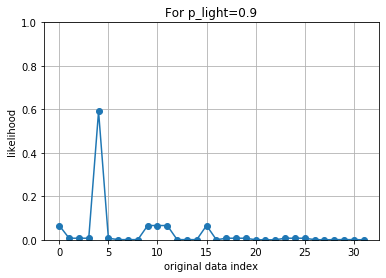

In [20]:
def plot_likelihood_distribution(likelihood_list):
    plt.plot(np.arange(len(likelihood_list)), likelihood_list, marker='o')
    plt.title(f'For p_light={p_light}')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.xlabel('original data index')
    plt.ylabel('likelihood')
    plt.show()
    
plot_likelihood_distribution(likelihood_list)

위의 그래프를 근거로 가능한 원본 데이터 목록 중에서 다섯 번째(인덱스 4)에 해당하는 [True False True True True]가 원본 데이터일 가능성이 가장 크다고 말할 수 있습니다.

이번에는 스피너의 밝은 부분이 차지하는 면적의 비율을 바꾸어 가면서 주어진 공개 데이터로부터 원본 데이터의 가능도 분포를 살펴 봅니다.

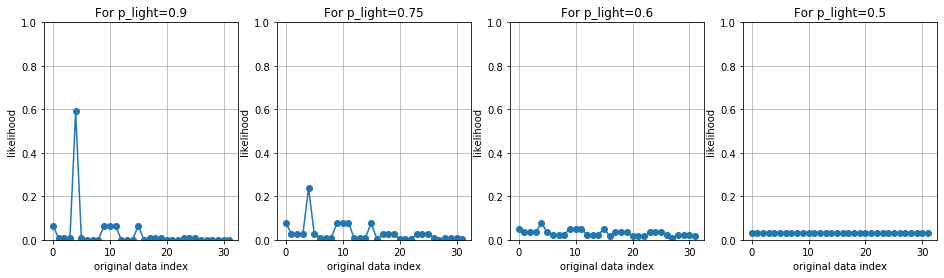

In [21]:
p_light_list = [0.9, 0.75, 0.6, 0.5]

plt.figure(figsize=(16,4))

for i in range(len(p_light_list)):
    p_light = p_light_list[i]
    spinner_probability_list = get_spinner_probability_list(p_light, N_patient, spinner_count_true_list)
    likelihood_list, _ = get_likelihood_list(original_patient_data_list, public_patient_data, spinner_data_list, spinner_probability_list)
    
    plt.subplot(141+i)
    plt.plot(np.arange(len(likelihood_list)), likelihood_list, marker='o')
    plt.title(f'For p_light={p_light}')
    plt.ylim(0, 1)
    plt.grid(True)
    plt.xlabel('original data index')
    plt.ylabel('likelihood')

plt.show()

스피너의 밝은 부분이 차지하는 면적의 비율이 클수록 원본 데이터의 값을 뒤집을 확률이 줄어듭니다. 이로 인해 공개 데이터로부터 원본 데이터를 추정할 때 좀 더 높은 확신을 가지고 말하는 것이 가능해집니다. 그와 반대로 스피너의 밝은 부분이 차지하는 면적이 절반에 가까워질수록 어떤 원본 데이터를 대상으로 스피너를 시행하더라도 공개 데이터를 얻을 가능성이 비슷해지므로 하나의 원본 데이터를 높은 확신을 가지고 지목하는 것이 어려워집니다.

## 5. 정리

공개 데이터가 주어질 때 원본 데이터들을 추정하고 각각의 가능성을 정량적으로 구하여 제시하였습니다. 이를 통해 스피너 시행 결과의 불확실성 정도에 따라 원본 데이터를 추정하는 난이도가 어떻게 달라지는지 알 수 있었습니다.